# <font color=orange><div align="center">SDP Project - RATP Complete Analysis</div></font>

### <font color=orange><div align="center">21/01/2026</div></font>
### <font color=orange><div align="center">Ouissal BOUTOUATOU - Alae TAOUDI - Mohammed SBAIHI</div></font>

---

## Contexte et Objectif du Projet

Dans le cadre de la modernisation du réseau RATP, il est crucial de **classifier les stations de métro selon leur importance stratégique** afin de prioriser les investissements en innovations et en rénovations. Face à des ressources limitées, toutes les stations ne peuvent être modernisées simultanément.

**Problématique centrale :** Comment identifier et classer les stations qui devraient bénéficier en priorité d'innovations technologiques, d'améliorations d'accessibilité, ou de travaux de rénovation?

### Approche Adoptée

Ce notebook présente une analyse complète basée sur:

1. **Décision Multicritère par Somme Pondérée** : Classification des stations selon 7 critères quantitatifs (fréquentation, priorité stratégique, dégradation, connectivité)

2. **Explicabilité par Trade-offs** : Pour chaque paire de stations, nous expliquons mathématiquement pourquoi une station est prioritaire par rapport à une autre, en identifiant les avantages qui compensent les désavantages

3. **Modélisation en Programmation Linéaire en Nombres Entiers (PLNE)** : Trois formulations optimales pour générer des explications minimales et compréhensibles

L'objectif est de fournir aux décideurs non seulement un classement des stations, mais aussi une **justification claire et quantifiable** de ce classement, facilitant ainsi la prise de décision et la communication des priorités d'investissement.

## Table des Matières

1. [Introduction et Chargement des Données](#1-introduction-et-chargement-des-données)
2. [Modèle de Préférence: Somme Pondérée](#2-modèle-de-préférence-somme-pondérée)
3. [Théorie des Trade-offs et Explicabilité](#3-théorie-des-trade-offs-et-explicabilité)
4. [Modélisation (1-m): Un Pro couvre Plusieurs Cons](#4-modélisation-1-m-un-pro-couvre-plusieurs-cons)
5. [Modélisation (m-1): Plusieurs Pros couvrent Un Con](#5-modélisation-m-1-plusieurs-pros-couvrent-un-con)
6. [Modélisation Hybride: Combinaison (1-m) et (m-1)](#6-modélisation-hybride-combinaison-1-m-et-m-1)
7. [Application: Analyse d'Explicabilité entre Stations](#7-application-analyse-dexplicabilité-entre-stations)

---
## 1. Introduction et Chargement des Données

Nous analysons un ensemble de stations RATP caractérisées par 7 critères quantitatifs:

- **A**: Passagers entrants par heure en heure de pointe (peak-entering-passengers/h)
- **B**: Passagers passants par heure en heure de pointe (peak-passing-passengers/h)
- **C**: Passagers entrants par heure hors pointe (off-peak-entering-passengers/h)
- **D**: Passagers passants par heure hors pointe (off-peak-passing-passengers/h)
- **E**: Priorité stratégique [échelle 0-10]
- **F**: Niveau de dégradation de la station [échelle 0-20]
- **G**: Indice de connectivité [échelle 0-100]

Chaque station est évaluée selon ces critères avec des poids spécifiques reflétant leur importance dans la décision multicritère.

In [21]:
import pandas as pd
from gurobipy import Model, GRB, quicksum
from typing import Union, List, Dict, Tuple

# Chargement des données
data = pd.read_csv('ratp.csv')
display(data)

,peak-entering-passengers/h,peak-passing-passengers/h,off-peak-entering-passengers/h,off-peak-passing-passengers/h,"strategic priority [0,10]","Station degradation level ([0,20] scale)","connectivity index [0,100]",name
0,85000,8100,35500,3450,75,16.2,88,Odéon (Ligne 4)
1,81000,8100,37500,3150,67,17.6,95,Place d'Italie (Lign 6)
2,74000,8900,37000,4050,68,16.8,79,Jussieu (Ligne 7)
3,74000,7100,42000,4550,77,15.2,73,Nation (Ligne 9)
4,72000,7500,33000,4250,88,13.2,93,La Motte Picquet-Grenelle (Ligne 10)
5,71000,7300,31500,4600,76,15.8,93,Porte d'Orléans (Ligne 4)
6,79000,6900,39000,3800,67,16.8,79,Daumenil (Ligne 6)
7,57000,7600,40500,3800,82,17.2,77,Vaugirard (Ligne 12)
8,84000,7900,34000,3300,74,15.8,85,Oberkampf (Ligne 9)
9,72000,8700,36000,4000,66,16.6,78,Reuilly-Diderot (Ligne 1)


---
## 2. Modèle de Préférence: Somme Pondérée

### 2.1 Formulation Mathématique

Pour un enregistrement (station) $r$ avec des valeurs $(v_1, v_2, ..., v_7)$ et des poids $(w_1, w_2, ..., w_7)$, le score est calculé comme:

$$
\text{Score}(r) = \sum_{i=1}^{7} w_i \cdot v_i
$$

Les poids utilisés reflètent l'importance relative de chaque critère:
- Critères E, F, G ont des poids très élevés (importance majeure)
- Critères B, D ont des poids modérés
- Critères A, C ont des poids faibles

In [22]:
# Définition des poids
WEIGHTS = [0.021, 0.188, 0.038, 0.322, 16.124, 67.183, 16.124]
FEATURES = ["A", "B", "C", "D", "E", "F", "G"]

def score(row):
    """Calcul du score pondéré pour une station"""
    s = 0
    for i, w in enumerate(WEIGHTS):
        s += row.iloc[i] * w
    return s

# Calcul et tri des scores
data['score'] = data.apply(lambda row: score(row), axis=1)
data = data.sort_values(by='score', ascending=False)

print("Stations classées par score décroissant:")
display(data[['score'] + list(data.columns[:-1])])

Stations classées par score décroissant:


,score,peak-entering-passengers/h,peak-passing-passengers/h,off-peak-entering-passengers/h,off-peak-passing-passengers/h,"strategic priority [0,10]","Station degradation level ([0,20] scale)","connectivity index [0,100]",name
0,9484.2766,85000,8100,35500,3450,75,16.2,88,Odéon (Ligne 4)
1,9457.6088,81000,8100,37500,3150,67,17.6,95,Place d'Italie (Lign 6)
2,9436.2024,74000,8900,37000,4050,68,16.8,79,Jussieu (Ligne 7)
3,9389.6816,74000,7100,42000,4550,77,15.2,73,Nation (Ligne 9)
4,9349.7596,72000,7500,33000,4250,88,13.2,93,La Motte Picquet-Grenelle (Ligne 10)
5,9328.0474,71000,7300,31500,4600,76,15.8,93,Porte d'Orléans (Ligne 4)
9,9240.6938,72000,8700,36000,4000,66,16.6,78,Reuilly-Diderot (Ligne 1)
8,9229.0074,84000,7900,34000,3300,74,15.8,85,Oberkampf (Ligne 9)
6,9144.5784,79000,6900,39000,3800,67,16.8,79,Daumenil (Ligne 6)
7,9107.6636,57000,7600,40500,3800,82,17.2,77,Vaugirard (Ligne 12)


In [23]:
# Fonctions utilitaires
def get_record(data, index):
    """Retourne l'enregistrement (liste de valeurs) à l'index donné"""
    return data.iloc[index].tolist()[:-2]

# Création d'un dictionnaire pour retrouver les noms
record_dict = {}
for i in range(len(data)):
    record = get_record(data, i)
    record_dict[tuple(record)] = data.iloc[i]['name']

def get_name(record):
    """Retourne le nom de la station correspondant à un enregistrement"""
    return record_dict[tuple(record)]

---
## 3. Théorie des Trade-offs et Explicabilité

### 3.1 Définition des Pros et Cons

Pour deux enregistrements $r_1$ et $r_2$ où $r_1$ est préféré à $r_2$:

**Pros (avantages de $r_1$ sur $r_2$)**:
$$
\text{Pros}(r_1, r_2) = \{i : w_i \cdot (r_1[i] - r_2[i]) > 0\}
$$

**Cons (désavantages de $r_1$ sur $r_2$)**:
$$
\text{Cons}(r_1, r_2) = \{i : w_i \cdot (r_1[i] - r_2[i]) < 0\}
$$

### 3.2 Concept de Trade-off

Un **trade-off** est une explication de la forme:
> "$r_1$ est préféré à $r_2$ car les avantages $P \subseteq \text{Pros}$ compensent les désavantages $C \subseteq \text{Cons}$"

Mathématiquement, un trade-off $(P, C)$ est **valide** si:
$$
\sum_{i \in P} w_i \cdot (r_1[i] - r_2[i]) + \sum_{j \in C} w_j \cdot (r_1[j] - r_2[j]) \geq \epsilon
$$

où $\epsilon > 0$ est un seuil de validité (typiquement 0.01).

In [24]:
# Paramètres globaux
EPSILON = 0.01  # Seuil de validité pour les trade-offs

def compute_pros_and_cons(record1: List[float], record2: List[float]) -> Tuple[Dict[int, float], Dict[int, float]]:
    """
    Calcule les pros et cons entre deux enregistrements.
    
    Args:
        record1: Premier enregistrement (7 valeurs)
        record2: Deuxième enregistrement (7 valeurs)
    
    Returns:
        pros: dictionnaire {index_feature -> contribution_positive}
        cons: dictionnaire {index_feature -> contribution_négative}
    """
    assert len(record1) == len(record2) == len(WEIGHTS), "Les enregistrements doivent avoir 7 features"
    
    pros = {
        i: (record1[i] - record2[i]) * WEIGHTS[i]
        for i in range(len(record1))
        if (record1[i] - record2[i]) > 0
    }
    
    cons = {
        i: (record1[i] - record2[i]) * WEIGHTS[i]
        for i in range(len(record1))
        if (record1[i] - record2[i]) < 0
    }
    
    return pros, cons

def print_contribution_table(record1: List[float], record2: List[float]) -> None:
    """Affiche un tableau des contributions pondérées"""
    print("\n" + "=" * 80)
    print("TABLE DE CONTRIBUTIONS PONDÉRÉES (Record 1 - Record 2)")
    print("=" * 80)
    
    # En-tête
    header = "|"
    separator = "|"
    for feature in FEATURES:
        header += f"   {feature}    |"
        separator += "---------|"
    print(header)
    print(separator)
    
    # Valeurs
    values = "|"
    for i in range(len(WEIGHTS)):
        diff = (record1[i] - record2[i]) * WEIGHTS[i]
        values += f" {diff:+7.3f} |"
    print(values)
    
    # Résumé
    total = sum((record1[i] - record2[i]) * WEIGHTS[i] for i in range(len(WEIGHTS)))
    print(separator)
    print(f"\nDifférence pondérée totale: {total:+.3f}")
    
    if total > 0:
        print("[>] Record 1 est préféré à Record 2")
    elif total < 0:
        print("[<] Record 2 est préféré à Record 1")
    else:
        print("[=] Les records sont équivalents")
    print()

---
## 4. Modélisation (1-m): Un Pro couvre Plusieurs Cons

### 4.1 Description

Dans une explication **(1-m)**, chaque trade-off a la forme $(p, \{c_1, c_2, ..., c_k\})$ où:
- Un seul **pro** $p$ est le pivot
- Plusieurs **cons** $\{c_1, ..., c_k\}$ sont couverts par ce pro

### 4.2 Formulation en Programmation Linéaire en Nombres Entiers (PLNE)

**Variables de décision:**
- $x_{p,c} \in \{0, 1\}$: 1 si le con $c$ est assigné au pro $p$
- $y_p \in \{0, 1\}$: 1 si le pro $p$ est utilisé comme pivot

**Contraintes:**
1. Couverture complète: $\sum_{p \in \text{Pros}} x_{p,c} = 1, \quad \forall c \in \text{Cons}$
2. Lien pivot-assignation: $x_{p,c} \leq y_p, \quad \forall p \in \text{Pros}, \forall c \in \text{Cons}$
3. Validité du trade-off: 
$$
\text{pros}[p] + \sum_{c \in \text{Cons}} x_{p,c} \cdot \text{cons}[c] \geq y_p \cdot \epsilon, \quad \forall p \in \text{Pros}
$$

**Objectif:**
$$
\min \sum_{p \in \text{Pros}} y_p
$$

(Minimiser le nombre de trade-offs)

In [25]:
def solve_1m_explanation(pros: Dict[int, float], cons: Dict[int, float], verbose: bool = True) -> dict:
    """
    Résout le problème d'explication (1-m): un pro couvre plusieurs cons.
    
    Args:
        pros: Dictionnaire {index_feature -> contribution_positive}
        cons: Dictionnaire {index_feature -> contribution_négative}
        verbose: Afficher les détails
    
    Returns:
        Dictionnaire contenant le résultat de l'optimisation
    """
    if not pros or not cons:
        return {"status": "trivial", "message": "Pas de pros ou cons à expliquer"}
    
    # Création du modèle
    m = Model("1-m_Explanation")
    m.setParam('OutputFlag', 0)  # Désactive la sortie Gurobi
    
    # Variables de décision
    # x[p,c] = 1 si le con c est assigné au pro p
    VarX = {(p, c): m.addVar(vtype=GRB.BINARY, name=f'x_{p}_{c}')
            for p in pros for c in cons}
    
    # y[p] = 1 si le pro p est utilisé comme pivot
    VarY = {p: m.addVar(vtype=GRB.BINARY, name=f'y_{p}')
            for p in pros}
    
    # Contraintes
    # 1. Chaque con doit être assigné à exactement un pro
    for c in cons:
        m.addConstr(quicksum(VarX[(p, c)] for p in pros) == 1, name=f"con_coverage_{c}")
    
    # 2. Si un con est assigné à un pro, ce pro doit être utilisé
    for p in pros:
        for c in cons:
            m.addConstr(VarX[(p, c)] <= VarY[p], name=f"link_{p}_{c}")
    
    # 3. Validité du trade-off: contribution pro + somme des cons assignés >= epsilon
    for p in pros:
        m.addConstr(
            pros[p] + quicksum(VarX[(p, c)] * cons[c] for c in cons) >= VarY[p] * EPSILON,
            name=f"validity_{p}"
        )
    
    # Objectif: minimiser le nombre de trade-offs (pros utilisés)
    m.setObjective(quicksum(VarY[p] for p in pros), GRB.MINIMIZE)
    
    # Résolution
    m.optimize()
    
    result = {"type": "1-m", "status": None, "tradeoffs": [], "num_tradeoffs": 0}
    
    if m.status == GRB.OPTIMAL:
        result["status"] = "optimal"
        result["num_tradeoffs"] = int(m.objVal)
        
        # Extraction de la solution
        for p in pros:
            if VarY[p].X > 0.5:  # Pro utilisé
                associated_cons = [c for c in cons if VarX[(p, c)].X > 0.5]
                total = pros[p] + sum(cons[c] for c in associated_cons)
                result["tradeoffs"].append({
                    "pro": p,
                    "cons": associated_cons,
                    "pro_contribution": pros[p],
                    "cons_contributions": {c: cons[c] for c in associated_cons},
                    "total": total
                })
        
        if verbose:
            print_1m_results(result)
    
    elif m.status == GRB.INFEASIBLE:
        result["status"] = "infeasible"
        if verbose:
            print("\n[!] Aucune explication (1-m) n'existe pour cette comparaison.")
    
    return result

def print_1m_results(result: dict) -> None:
    """Affiche les résultats de l'explication (1-m)"""
    print("\n" + "=" * 80)
    print("EXPLICATION (1-m) OPTIMALE TROUVÉE!")
    print("=" * 80)
    print(f"\nNombre minimum de trade-offs: {result['num_tradeoffs']}")
    print("\n" + "-" * 80)
    print("TRADE-OFFS:")
    print("-" * 80)
    
    for to in result["tradeoffs"]:
        pro_name = FEATURES[to["pro"]]
        cons_names = [FEATURES[c] for c in to["cons"]]
        
        print(f"\n  Trade-off: ({pro_name}, {{{', '.join(cons_names)}}}")
        print(f"    - Contribution Pro [{pro_name}]: {to['pro_contribution']:+.3f}")
        for c in to["cons"]:
            print(f"    - Contribution Con [{FEATURES[c]}]: {to['cons_contributions'][c]:+.3f}")
        print(f"    - Total: {to['total']:+.3f}")
        print(f"    - Valide: {to['total'] > 0}")

---
## 5. Modélisation (m-1): Plusieurs Pros couvrent Un Con

### 5.1 Description

Dans une explication **(m-1)**, chaque trade-off a la forme $(\{p_1, p_2, ..., p_k\}, c)$ où:
- Plusieurs **pros** $\{p_1, ..., p_k\}$ sont combinés
- Un seul **con** $c$ est le pivot

### 5.2 Formulation en PLNE

**Variables de décision:**
- $x_{p,c} \in \{0, 1\}$: 1 si le pro $p$ est assigné au con $c$

**Contraintes:**
1. Usage unique des pros: $\sum_{c \in \text{Cons}} x_{p,c} \leq 1, \quad \forall p \in \text{Pros}$
2. Couverture des cons: $\sum_{p \in \text{Pros}} x_{p,c} \geq 1, \quad \forall c \in \text{Cons}$
3. Validité du trade-off:
$$
\sum_{p \in \text{Pros}} x_{p,c} \cdot \text{pros}[p] + \text{cons}[c] \geq \epsilon, \quad \forall c \in \text{Cons}
$$

**Objectif:**
$$
\min \sum_{p \in \text{Pros}} \sum_{c \in \text{Cons}} x_{p,c}
$$

(Minimiser le nombre total de pros utilisés)

In [26]:
def solve_m1_explanation(pros: Dict[int, float], cons: Dict[int, float], verbose: bool = True) -> dict:
    """
    Résout le problème d'explication (m-1): plusieurs pros couvrent un con.
    
    Args:
        pros: Dictionnaire {index_feature -> contribution_positive}
        cons: Dictionnaire {index_feature -> contribution_négative}
        verbose: Afficher les détails
    
    Returns:
        Dictionnaire contenant le résultat de l'optimisation
    """
    if not pros or not cons:
        return {"status": "trivial", "message": "Pas de pros ou cons à expliquer"}
    
    # Création du modèle
    m = Model("m-1_Explanation")
    m.setParam('OutputFlag', 0)
    
    # Variables de décision
    # x[p,c] = 1 si le pro p est assigné au con c
    VarX = {(p, c): m.addVar(vtype=GRB.BINARY, name=f'x_{p}_{c}')
            for p in pros for c in cons}
    
    # Contraintes
    # 1. Chaque pro peut être assigné à au plus un con
    for p in pros:
        m.addConstr(quicksum(VarX[(p, c)] for c in cons) <= 1, name=f"pro_usage_{p}")
    
    # 2. Chaque con doit avoir au moins un pro assigné
    for c in cons:
        m.addConstr(quicksum(VarX[(p, c)] for p in pros) >= 1, name=f"con_coverage_{c}")
    
    # 3. Validité du trade-off: somme des pros assignés + contribution con >= epsilon
    for c in cons:
        m.addConstr(
            quicksum(VarX[(p, c)] * pros[p] for p in pros) + cons[c] >= EPSILON,
            name=f"validity_{c}"
        )
    
    # Objectif: minimiser le nombre total de pros utilisés
    m.setObjective(quicksum(VarX[(p, c)] for p in pros for c in cons), GRB.MINIMIZE)
    
    # Résolution
    m.optimize()
    
    result = {"type": "m-1", "status": None, "tradeoffs": [], "num_pros_used": 0}
    
    if m.status == GRB.OPTIMAL:
        result["status"] = "optimal"
        result["num_pros_used"] = int(m.objVal)
        
        # Extraction de la solution
        for c in cons:
            associated_pros = [p for p in pros if VarX[(p, c)].X > 0.5]
            if associated_pros:
                total = sum(pros[p] for p in associated_pros) + cons[c]
                result["tradeoffs"].append({
                    "con": c,
                    "pros": associated_pros,
                    "pros_contributions": {p: pros[p] for p in associated_pros},
                    "con_contribution": cons[c],
                    "total": total
                })
        
        if verbose:
            print_m1_results(result)
    
    elif m.status == GRB.INFEASIBLE:
        result["status"] = "infeasible"
        if verbose:
            print("\n[!] Aucune explication (m-1) n'existe pour cette comparaison.")
    
    return result

def print_m1_results(result: dict) -> None:
    """Affiche les résultats de l'explication (m-1)"""
    print("\n" + "=" * 80)
    print("EXPLICATION (m-1) OPTIMALE TROUVÉE!")
    print("=" * 80)
    print(f"\nNombre total de pros utilisés: {result['num_pros_used']}")
    print("\n" + "-" * 80)
    print("TRADE-OFFS:")
    print("-" * 80)
    
    for to in result["tradeoffs"]:
        con_name = FEATURES[to["con"]]
        pros_names = [FEATURES[p] for p in to["pros"]]
        
        print(f"\n  Trade-off: ({{{', '.join(pros_names)}}}, {con_name})")
        for p in to["pros"]:
            print(f"    - Contribution Pro [{FEATURES[p]}]: {to['pros_contributions'][p]:+.3f}")
        print(f"    - Contribution Con [{con_name}]: {to['con_contribution']:+.3f}")
        print(f"    - Total: {to['total']:+.3f}")
        print(f"    - Valide: {to['total'] > 0}")

---
## 6. Modélisation Hybride: Combinaison (1-m) et (m-1)

### 6.1 Description

L'explication **hybride** combine les deux types de trade-offs:
- Certains pros servent de pivots pour couvrir plusieurs cons (type 1-m)
- Certains cons servent de pivots couverts par plusieurs pros (type m-1)

### 6.2 Formulation en PLNE

**Variables de décision:**
- $\text{atp}_{p,c} \in \{0, 1\}$: 1 si con $c$ est assigné au pivot pro $p$ (relation 1-m)
- $\text{atc}_{p,c} \in \{0, 1\}$: 1 si pro $p$ est assigné au pivot con $c$ (relation m-1)
- $\text{piv}_p \in \{0, 1\}$: 1 si pro $p$ est un pivot (1-m)
- $\text{piv}_c \in \{0, 1\}$: 1 si con $c$ est un pivot (m-1)

**Contraintes principales:**
1. Couverture des cons:
$$
\text{piv}_c + \sum_{p \in \text{Pros}} \text{atp}_{p,c} = 1, \quad \forall c \in \text{Cons}
$$

2. Usage des pros:
$$
\text{piv}_p + \sum_{c \in \text{Cons}} \text{atc}_{p,c} \leq 1, \quad \forall p \in \text{Pros}
$$

3. Validité (1-m):
$$
\text{pros}[p] + \sum_{c \in \text{Cons}} \text{atp}_{p,c} \cdot \text{cons}[c] \geq \text{piv}_p \cdot \epsilon
$$

4. Validité (m-1) avec Big-M:
$$
\text{cons}[c] + \sum_{p \in \text{Pros}} \text{atc}_{p,c} \cdot \text{pros}[p] \geq \text{piv}_c \cdot \epsilon - (1 - \text{piv}_c) \cdot M
$$

**Objectif:**
$$
\min \sum_{p \in \text{Pros}} \text{piv}_p + \sum_{c \in \text{Cons}} \text{piv}_c
$$

(Minimiser le nombre total de pivots)

In [27]:
def compute_dynamic_bigM(pros: Dict[int, float], cons: Dict[int, float]) -> float:
    """
    Calcule un Big-M adaptatif pour éviter les problèmes numériques.
    Big-M = somme des valeurs absolues de tous les cons + 1
    """
    total_negative = sum(abs(c) for c in cons.values())
    return total_negative + 1

def solve_hybrid_explanation(pros: Dict[int, float], cons: Dict[int, float], verbose: bool = True) -> dict:
    """
    Résout le problème d'explication hybride: combinaison de (1-m) et (m-1).
    
    Args:
        pros: Dictionnaire {index_feature -> contribution_positive}
        cons: Dictionnaire {index_feature -> contribution_négative}
        verbose: Afficher les détails
    
    Returns:
        Dictionnaire contenant le résultat de l'optimisation
    """
    if not pros or not cons:
        return {"status": "trivial", "message": "Pas de pros ou cons à expliquer"}
    
    # Création du modèle
    m = Model("Hybrid_Explanation")
    m.setParam('OutputFlag', 0)
    
    # Calcul du Big-M adaptatif
    BIG_M = compute_dynamic_bigM(pros, cons)
    
    if verbose:
        print(f"Big-M dynamique calculé: {BIG_M:.3f}")
    
    # Variables de décision
    # Variables d'assignation
    VarAssignPro = {(p, c): m.addVar(vtype=GRB.BINARY, name=f'atp_{p}_{c}')
                    for p in pros for c in cons}
    VarAssignCon = {(p, c): m.addVar(vtype=GRB.BINARY, name=f'atc_{p}_{c}')
                    for p in pros for c in cons}
    
    # Variables de pivot
    VarPivotPro = {p: m.addVar(vtype=GRB.BINARY, name=f'piv_p_{p}') for p in pros}
    VarPivotCon = {c: m.addVar(vtype=GRB.BINARY, name=f'piv_c_{c}') for c in cons}
    
    # Contraintes
    # 1. Chaque con doit être couvert exactement une fois
    for c in cons:
        m.addConstr(
            VarPivotCon[c] + quicksum(VarAssignPro[(p, c)] for p in pros) == 1,
            name=f"coverage_con_{c}"
        )
    
    # 2. Chaque pro peut être utilisé au plus une fois
    for p in pros:
        m.addConstr(
            VarPivotPro[p] + quicksum(VarAssignCon[(p, c)] for c in cons) <= 1,
            name=f"usage_pro_{p}"
        )
    
    # 3. Contraintes de liaison
    for p in pros:
        for c in cons:
            m.addConstr(VarAssignPro[(p, c)] <= VarPivotPro[p], name=f"link_atp_{p}_{c}")
            m.addConstr(VarAssignCon[(p, c)] <= VarPivotCon[c], name=f"link_atc_{p}_{c}")
    
    # 4. Contraintes de participation minimale
    for p in pros:
        m.addConstr(
            quicksum(VarAssignPro[(p, c)] for c in cons) >= VarPivotPro[p],
            name=f"min_participation_pro_{p}"
        )
    
    for c in cons:
        m.addConstr(
            quicksum(VarAssignCon[(p, c)] for p in pros) >= VarPivotCon[c],
            name=f"min_participation_con_{c}"
        )
    
    # 5. Validité des trade-offs (1-m)
    for p in pros:
        m.addConstr(
            pros[p] + quicksum(VarAssignPro[(p, c)] * cons[c] for c in cons)
            >= VarPivotPro[p] * EPSILON,
            name=f"validity_1m_{p}"
        )
    
    # 6. Validité des trade-offs (m-1) avec Big-M
    for c in cons:
        m.addConstr(
            cons[c] + quicksum(VarAssignCon[(p, c)] * pros[p] for p in pros)
            >= VarPivotCon[c] * EPSILON - (1 - VarPivotCon[c]) * BIG_M,
            name=f"validity_m1_{c}"
        )
    
    # Objectif: minimiser le nombre total de pivots
    m.setObjective(
        quicksum(VarPivotPro[p] for p in pros) + quicksum(VarPivotCon[c] for c in cons),
        GRB.MINIMIZE
    )
    
    # Résolution
    m.optimize()
    
    result = {
        "type": "hybrid",
        "status": None,
        "tradeoffs_1m": [],
        "tradeoffs_m1": [],
        "num_pivots": 0
    }
    
    if m.status == GRB.OPTIMAL:
        result["status"] = "optimal"
        result["num_pivots"] = int(m.objVal)
        
        # Extraction des trade-offs (1-m)
        for p in pros:
            if VarPivotPro[p].X > 0.5:
                associated_cons = [c for c in cons if VarAssignPro[(p, c)].X > 0.5]
                total = pros[p] + sum(cons[c] for c in associated_cons)
                result["tradeoffs_1m"].append({
                    "pro": p,
                    "cons": associated_cons,
                    "pro_contribution": pros[p],
                    "cons_contributions": {c: cons[c] for c in associated_cons},
                    "total": total
                })
        
        # Extraction des trade-offs (m-1)
        for c in cons:
            if VarPivotCon[c].X > 0.5:
                associated_pros = [p for p in pros if VarAssignCon[(p, c)].X > 0.5]
                total = sum(pros[p] for p in associated_pros) + cons[c]
                result["tradeoffs_m1"].append({
                    "con": c,
                    "pros": associated_pros,
                    "pros_contributions": {p: pros[p] for p in associated_pros},
                    "con_contribution": cons[c],
                    "total": total
                })
        
        if verbose:
            print_hybrid_results(result)
    
    elif m.status == GRB.INFEASIBLE:
        result["status"] = "infeasible"
        if verbose:
            print("\n[!] Aucune explication hybride n'existe pour cette comparaison.")
    
    return result

def print_hybrid_results(result: dict) -> None:
    """Affiche les résultats de l'explication hybride"""
    print("\n" + "=" * 80)
    print("EXPLICATION HYBRIDE OPTIMALE TROUVÉE!")
    print("=" * 80)
    print(f"\nNombre minimum de pivots: {result['num_pivots']}")
    
    if result["tradeoffs_1m"]:
        print("\n" + "-" * 80)
        print("TRADE-OFFS (1-m):")
        print("-" * 80)
        for to in result["tradeoffs_1m"]:
            pro_name = FEATURES[to["pro"]]
            cons_names = [FEATURES[c] for c in to["cons"]]
            
            print(f"\n  Trade-off: ({pro_name}, {{{', '.join(cons_names)}}}")
            print(f"    - Contribution Pro [{pro_name}]: {to['pro_contribution']:+.3f}")
            for c in to["cons"]:
                print(f"    - Contribution Con [{FEATURES[c]}]: {to['cons_contributions'][c]:+.3f}")
            print(f"    - Total: {to['total']:+.3f}")
    
    if result["tradeoffs_m1"]:
        print("\n" + "-" * 80)
        print("TRADE-OFFS (m-1):")
        print("-" * 80)
        for to in result["tradeoffs_m1"]:
            con_name = FEATURES[to["con"]]
            pros_names = [FEATURES[p] for p in to["pros"]]
            
            print(f"\n  Trade-off: ({{{', '.join(pros_names)}}}, {con_name})")
            for p in to["pros"]:
                print(f"    - Contribution Pro [{FEATURES[p]}]: {to['pros_contributions'][p]:+.3f}")
            print(f"    - Contribution Con [{con_name}]: {to['con_contribution']:+.3f}")
            print(f"    - Total: {to['total']:+.3f}")

---
## Fonction Principale d'Explication

Cette fonction unifie les trois types d'explications et gère automatiquement la validation des préférences.

In [28]:
def find_explanation(
    record1: List[float],
    record2: List[float],
    explanation_type: Union[str, List[str]] = "1-m",
    verbose: bool = True
) -> dict:
    """
    Trouve une explication pour pourquoi record1 est préféré à record2.
    
    Args:
        record1: Premier enregistrement (7 valeurs)
        record2: Deuxième enregistrement (7 valeurs)
        explanation_type: Type d'explication:
            - "1-m": Un pro couvre plusieurs cons
            - "m-1": Plusieurs pros couvrent un con
            - ["1-m", "m-1"]: Hybride (combinaison des deux)
        verbose: Afficher les détails
    
    Returns:
        Dictionnaire contenant le résultat de l'explication
    """
    assert len(record1) == len(record2) == 7, "Les enregistrements doivent avoir 7 features"
    
    # Affichage de la table de contributions
    if verbose:
        print_contribution_table(record1, record2)
    
    # Calcul des pros et cons
    pros, cons = compute_pros_and_cons(record1, record2)
    
    if verbose:
        print("=" * 80)
        print("ANALYSE DES PROS ET CONS")
        print("=" * 80)
        print(f"\nPros (contributions positives):")
        for idx, val in pros.items():
            print(f"  {FEATURES[idx]}: {val:+.3f}")
        print(f"\nCons (contributions négatives):")
        for idx, val in cons.items():
            print(f"  {FEATURES[idx]}: {val:+.3f}")
    
    # Vérification de la validité de la comparaison
    total = sum(pros.values()) + sum(cons.values())
    if total <= 0:
        if verbose:
            print(f"\n[!] Record 1 n'est PAS préféré à Record 2 (total: {total:+.3f})")
            print("    Aucune explication nécessaire/possible.")
        return {"status": "not_preferred", "message": "Record 1 n'est pas préféré à Record 2"}
    
    if not cons:
        if verbose:
            print("\n[>>] Explication triviale: Record 1 domine Record 2 sur tous les critères.")
        return {"status": "trivial", "message": "Record 1 domine Record 2"}
    
    # Détermination du solveur à utiliser
    if isinstance(explanation_type, list):
        # Explication hybride
        if verbose:
            print("\n" + "=" * 80)
            print("RÉSOLUTION POUR EXPLICATION HYBRIDE (1-m + m-1)")
            print("=" * 80)
        return solve_hybrid_explanation(pros, cons, verbose)
    
    elif explanation_type == "1-m":
        if verbose:
            print("\n" + "=" * 80)
            print("RÉSOLUTION POUR EXPLICATION (1-m)")
            print("=" * 80)
        return solve_1m_explanation(pros, cons, verbose)
    
    elif explanation_type == "m-1":
        if verbose:
            print("\n" + "=" * 80)
            print("RÉSOLUTION POUR EXPLICATION (m-1)")
            print("=" * 80)
        return solve_m1_explanation(pros, cons, verbose)
    
    else:
        raise ValueError(f"Type d'explication inconnu: {explanation_type}")

---
## 7. Application: Analyse d'Explicabilité entre Stations

Nous analysons maintenant toutes les paires de stations pour déterminer:
1. Quel type d'explication existe (1-m, m-1, ou hybride)
2. Quelles paires de stations ne peuvent pas être expliquées

### 7.1 Méthodologie

Pour chaque station $s_i$ (classée par score décroissant):
- Comparer avec toutes les stations $s_j$ où $j > i$ (scores inférieurs)
- Tenter de trouver une explication de type 1-m, m-1, puis hybride
- Enregistrer le type d'explication trouvé ou l'absence d'explication

In [29]:
# Définition des types d'explication à tester
EXPLANATION_TYPES = ["1-m", "m-1", ["1-m", "m-1"]]

explainabilities = {}    # map: station -> dict {station: liste de types d'explication}
unexplainabilities = {}  # map: station -> liste de stations non explicables

print("Début de l'analyse d'explicabilité...")
print(f"Nombre total de stations: {len(data)}")
print(f"Nombre de comparaisons à effectuer: {len(data) * (len(data) - 1) // 2}")

# Parcours de toutes les paires de stations
for i in range(len(data)):
    record1 = get_record(data, i)
    station1_name = get_name(record1)
    
    for j in range(i+1, len(data)):
        record2 = get_record(data, j)
        station2_name = get_name(record2)
        
        explanation_values = {station2_name: []}
        explanation_found = False
        
        # Test de chaque type d'explication
        for explanation_type in EXPLANATION_TYPES:
            explanation = find_explanation(record1, record2, explanation_type, verbose=False)
            
            if explanation and explanation["status"] not in ["infeasible", "not_preferred", "trivial"]:
                if explanation_type == "1-m":
                    explanation_values[station2_name].append("1-m")
                    explainabilities.setdefault(station1_name, {}).update(explanation_values)
                    explanation_found = True
                elif explanation_type == "m-1":
                    explanation_values[station2_name].append("m-1")
                    explainabilities.setdefault(station1_name, {}).update(explanation_values)
                    explanation_found = True
                elif explanation_type == ["1-m", "m-1"]:
                    explanation_values[station2_name].append("hybrid")
                    explainabilities.setdefault(station1_name, {}).update(explanation_values)
                    explanation_found = True
        
        # Si aucune explication n'a été trouvée
        if not explanation_found:
            unexplainabilities.setdefault(station1_name, []).append(station2_name)

Début de l'analyse d'explicabilité...
Nombre total de stations: 10
Nombre de comparaisons à effectuer: 45


### 7.2 Résultats de l'Analyse

Affichage détaillé des résultats pour chaque station:

In [30]:
# Affichage des résultats
print("\n" + "=" * 80)
print("RÉSULTATS D'EXPLICABILITÉ PAR STATION")
print("=" * 80)

num_stations = len(data)
for idx, station in enumerate(explainabilities.keys()):
    remaining = num_stations - idx - 1
    
    print(f"\n{'='*80}")
    print(f"Station: {station}")
    print(f"{'='*80}")
    
    # Stations expliquées
    num_explained = len(explainabilities[station])
    print(f"\nExplication trouvée pour {num_explained}/{remaining} stations:")
    for explained_station, explanation_types in explainabilities[station].items():
        types_str = ', '.join(explanation_types)
        print(f"    ==> {explained_station} via {types_str}")
    
    # Stations non expliquées
    num_unexplained = len(unexplainabilities.get(station, []))
    if num_unexplained > 0:
        print(f"\nAucune explication trouvée pour {num_unexplained}/{remaining} stations:")
        print(f"    ==> {', '.join(unexplainabilities[station])}")
    else:
        print(f"\n==> Toutes les stations inférieures sont explicables!")

print("\n" + "=" * 80)


RÉSULTATS D'EXPLICABILITÉ PAR STATION

Station: Odéon (Ligne 4)

Explication trouvée pour 6/9 stations:
    ==> Place d'Italie (Lign 6) via 1-m, m-1, hybrid
    ==> La Motte Picquet-Grenelle (Ligne 10) via m-1, hybrid
    ==> Porte d'Orléans (Ligne 4) via m-1, hybrid
    ==> Reuilly-Diderot (Ligne 1) via 1-m, hybrid
    ==> Daumenil (Ligne 6) via 1-m, m-1, hybrid
    ==> Vaugirard (Ligne 12) via 1-m, hybrid

Aucune explication trouvée pour 3/9 stations:
    ==> Jussieu (Ligne 7), Nation (Ligne 9), Oberkampf (Ligne 9)

Station: Place d'Italie (Lign 6)

Explication trouvée pour 7/8 stations:
    ==> Nation (Ligne 9) via hybrid
    ==> La Motte Picquet-Grenelle (Ligne 10) via m-1, hybrid
    ==> Porte d'Orléans (Ligne 4) via m-1, hybrid
    ==> Reuilly-Diderot (Ligne 1) via 1-m, m-1, hybrid
    ==> Oberkampf (Ligne 9) via 1-m, m-1, hybrid
    ==> Daumenil (Ligne 6) via 1-m, m-1, hybrid
    ==> Vaugirard (Ligne 12) via 1-m, m-1, hybrid

Aucune explication trouvée pour 1/8 stations:
    ==

### 7.3 Statistiques Globales

In [31]:
# Calcul des statistiques
total_comparisons = len(data) * (len(data) - 1) // 2
total_explained = sum(len(expl) for expl in explainabilities.values())
total_unexplained = sum(len(unexpl) for unexpl in unexplainabilities.values())

# Comptage par type d'explication
count_1m = 0
count_m1 = 0
count_hybrid = 0

for station_explanations in explainabilities.values():
    for explanation_types in station_explanations.values():
        if "1-m" in explanation_types:
            count_1m += 1
        if "m-1" in explanation_types:
            count_m1 += 1
        if "hybrid" in explanation_types:
            count_hybrid += 1

print("\n" + "=" * 80)
print("STATISTIQUES GLOBALES")
print("=" * 80)
print(f"\nNombre total de comparaisons: {total_comparisons}")
print(f"Comparaisons explicables: {total_explained} ({100*total_explained/total_comparisons:.1f}%)")
print(f"Comparaisons non explicables: {total_unexplained} ({100*total_unexplained/total_comparisons:.1f}%)")
print(f"\nRépartition par type d'explication:")
print(f"  - (1-m): {count_1m} comparaisons")
print(f"  - (m-1): {count_m1} comparaisons")
print(f"  - Hybride: {count_hybrid} comparaisons")
print("\nNote: Une même comparaison peut avoir plusieurs types d'explication valides.")
print("=" * 80)


STATISTIQUES GLOBALES

Nombre total de comparaisons: 45
Comparaisons explicables: 36 (80.0%)
Comparaisons non explicables: 9 (20.0%)

Répartition par type d'explication:
  - (1-m): 22 comparaisons
  - (m-1): 21 comparaisons
  - Hybride: 36 comparaisons

Note: Une même comparaison peut avoir plusieurs types d'explication valides.


### 7.4 Graphe de Préférences Explicables

Visualisation du réseau d'explicabilité entre stations. Chaque nœud représente une station, et chaque arête orientée $(a, b)$ indique que la préférence de la station $a$ sur la station $b$ peut être expliquée. Les couleurs/styles d'arêtes indiquent le type d'explication disponible.

In [32]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import numpy as np

# graphe orienté
G = nx.DiGraph()

# nœuds
station_names = [get_name(get_record(data, i)) for i in range(len(data))]
G.add_nodes_from(station_names)

# arêtes
edge_types = {}  # (source, target) -> list of explanation types

for station_from, explanations in explainabilities.items():
    for station_to, explanation_types in explanations.items():
        G.add_edge(station_from, station_to)
        edge_types[(station_from, station_to)] = explanation_types

print(f"Graphe créé avec {G.number_of_nodes()} nœuds et {G.number_of_edges()} arêtes")
print(f"Densité du graphe: {nx.density(G):.3f}")


Graphe créé avec 10 nœuds et 36 arêtes
Densité du graphe: 0.400


In [33]:
# Classification des arêtes par type d'explication
edges_1m_only = []
edges_m1_only = []
edges_hybrid_only = []
edges_1m_m1 = []
edges_1m_hybrid = []
edges_m1_hybrid = []
edges_all_three = []

for (source, target), types in edge_types.items():
    types_set = set(types)
    
    if types_set == {"1-m"}:
        edges_1m_only.append((source, target))
    elif types_set == {"m-1"}:
        edges_m1_only.append((source, target))
    elif types_set == {"hybrid"}:
        edges_hybrid_only.append((source, target))
    elif types_set == {"1-m", "m-1"}:
        edges_1m_m1.append((source, target))
    elif types_set == {"1-m", "hybrid"}:
        edges_1m_hybrid.append((source, target))
    elif types_set == {"m-1", "hybrid"}:
        edges_m1_hybrid.append((source, target))
    elif types_set == {"1-m", "m-1", "hybrid"}:
        edges_all_three.append((source, target))

print("Classification des arêtes par type d'explication:")
print(f"  - Uniquement (1-m): {len(edges_1m_only)}")
print(f"  - Uniquement (m-1): {len(edges_m1_only)}")
print(f"  - Uniquement Hybride: {len(edges_hybrid_only)}")
print(f"  - (1-m) + (m-1): {len(edges_1m_m1)}")
print(f"  - (1-m) + Hybride: {len(edges_1m_hybrid)}")
print(f"  - (m-1) + Hybride: {len(edges_m1_hybrid)}")
print(f"  - Tous les trois: {len(edges_all_three)}")


Classification des arêtes par type d'explication:
  - Uniquement (1-m): 0
  - Uniquement (m-1): 0
  - Uniquement Hybride: 4
  - (1-m) + (m-1): 0
  - (1-m) + Hybride: 11
  - (m-1) + Hybride: 10
  - Tous les trois: 11


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


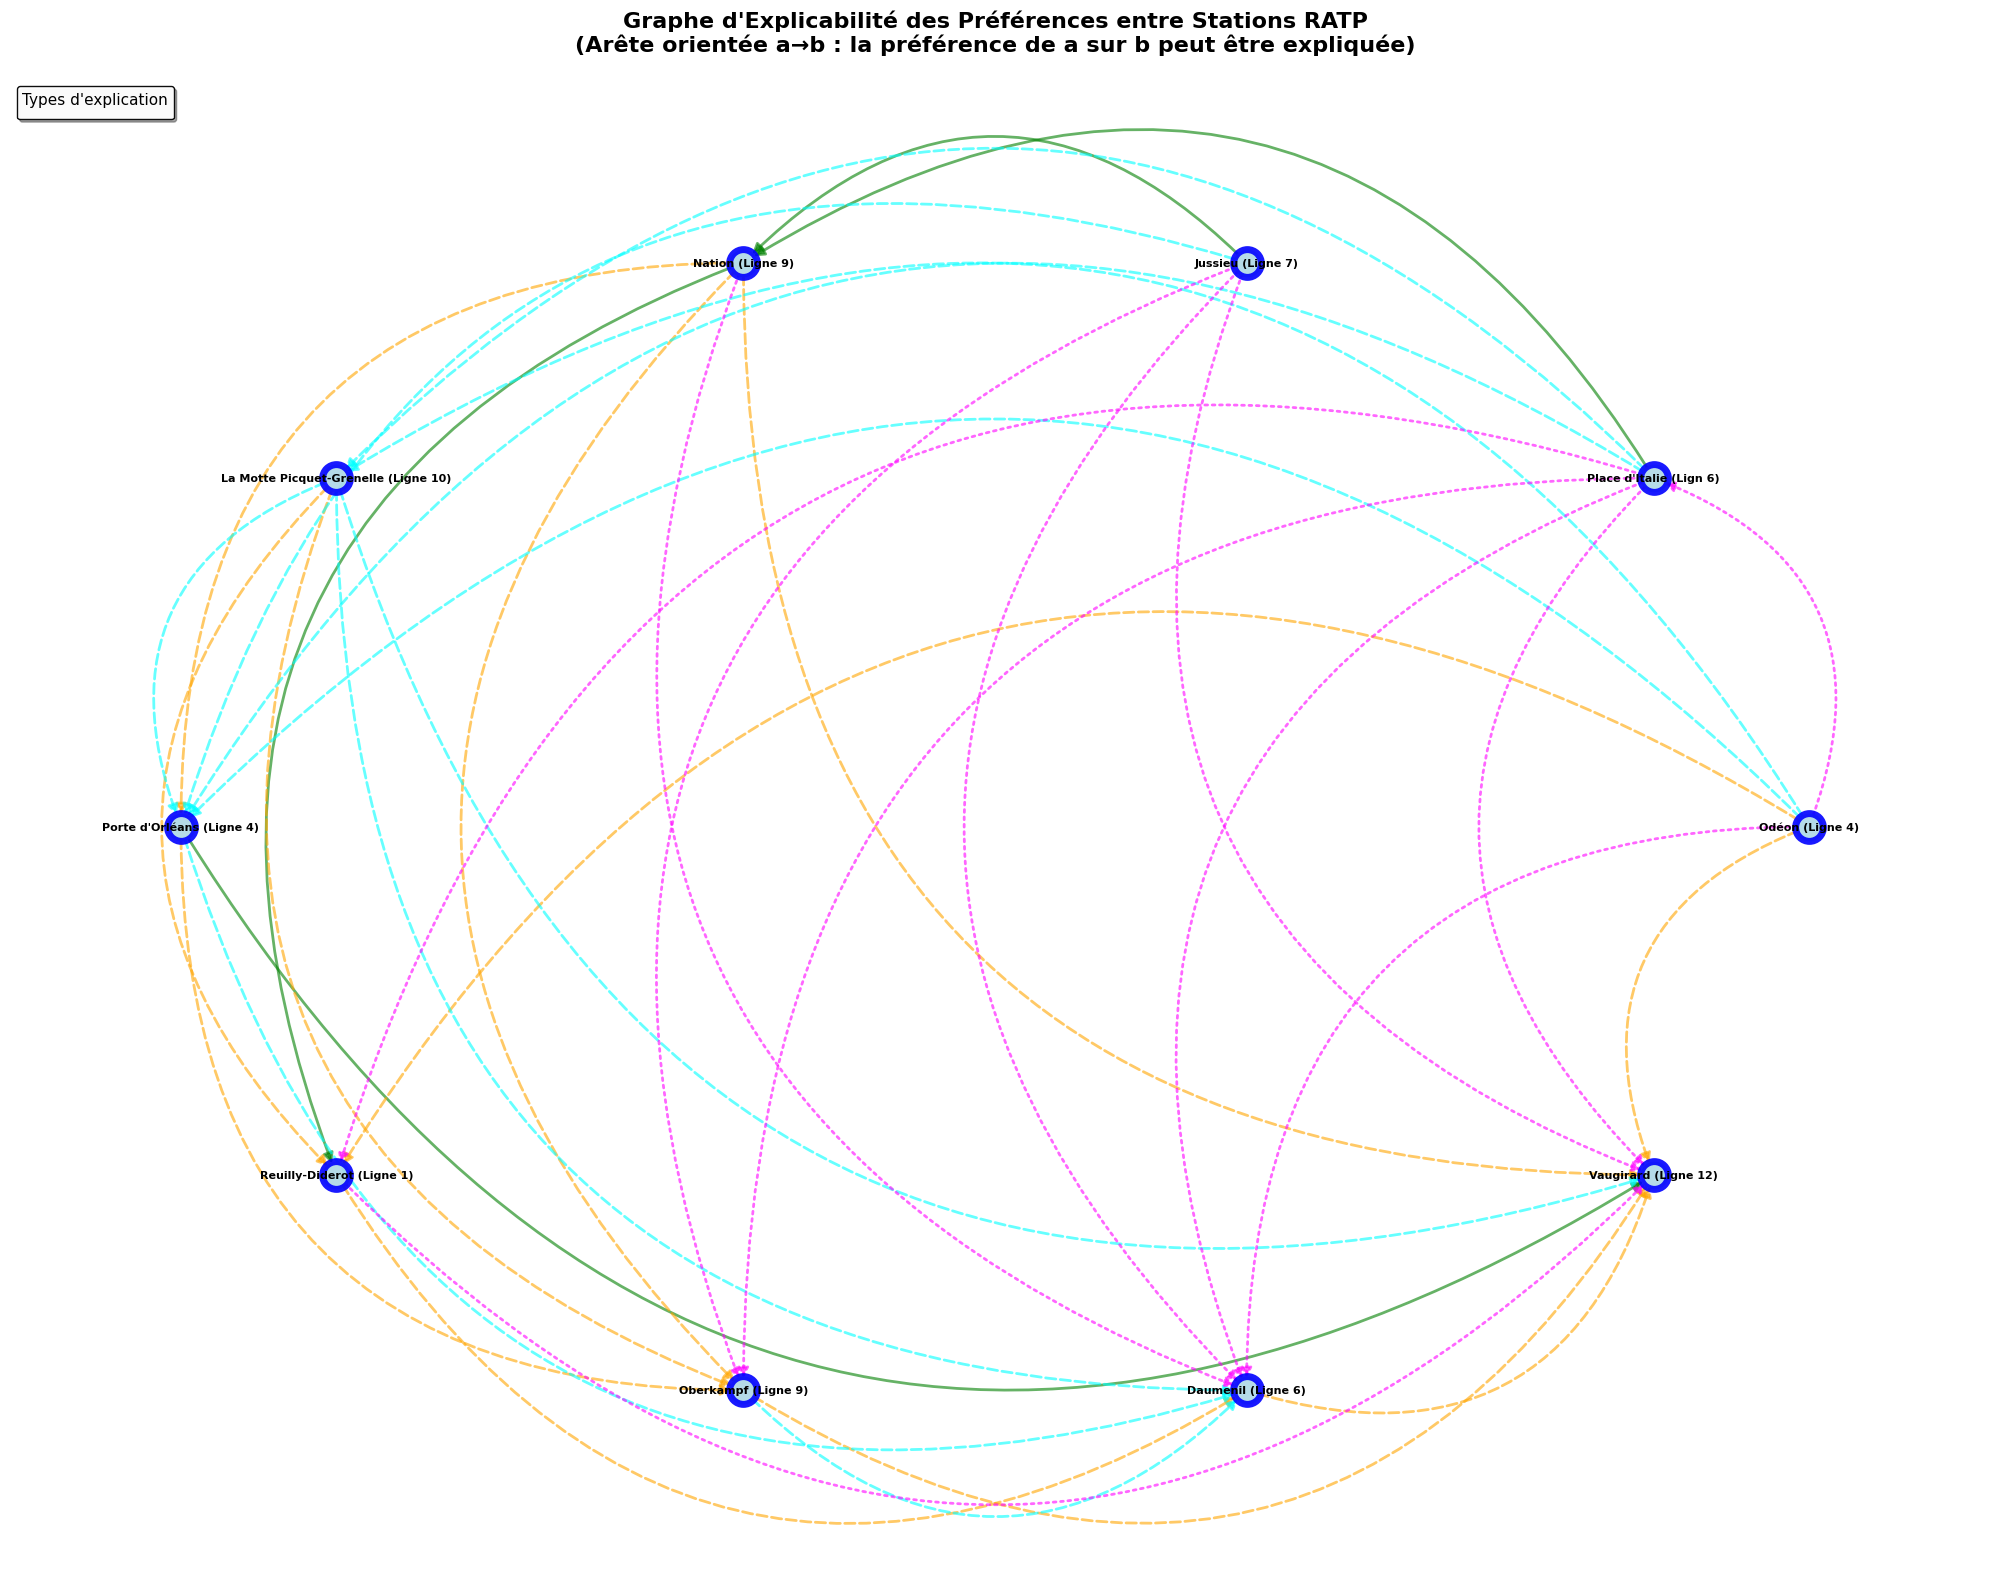


Le graphe montre les relations d'explicabilité:
  - Chaque nœud = une station RATP
  - Arête a→b = la préférence de a sur b est explicable
  - Couleur/style = type(s) d'explication disponible(s)


In [45]:
plt.figure(figsize=(20, 16))

# Positionnement des nœuds (disposition hiérarchique basée sur le score)
# Créer une disposition en couches basée sur le classement
pos = {}
scores_dict = dict(zip(data['name'], data['score']))

# Disposition circulaire avec ordre par score
sorted_stations = sorted(station_names, key=lambda x: scores_dict[x], reverse=True)
n = len(sorted_stations)
for i, station in enumerate(sorted_stations):
    angle = 2 * np.pi * i / n
    radius = 10
    pos[station] = (radius * np.cos(angle), radius * np.sin(angle))

# Dessiner les nœuds
nx.draw_networkx_nodes(G, pos, 
                       node_color='lightblue', 
                       node_size=400,
                       alpha=0.9,
                       edgecolors='blue',
                       linewidths=5)

# différentes couleurs selon le type
edge_styles = [
    (edges_1m_only, 'red', 'solid', 'Uniquement (1-m): 1 Pro → Plusieurs Cons'),
    (edges_m1_only, 'blue', 'solid', 'Uniquement (m-1): Plusieurs Pros → 1 Con'),
    (edges_hybrid_only, 'green', 'solid', 'Uniquement Hybride'),
    (edges_1m_m1, 'purple', 'dashed', '(1-m) + (m-1)'),
    (edges_1m_hybrid, 'orange', 'dashed', '(1-m) + Hybride'),
    (edges_m1_hybrid, 'cyan', 'dashed', '(m-1) + Hybride'),
    (edges_all_three, 'magenta', 'dotted', 'Tous les trois types')
]

for edges, color, style, label in edge_styles:
    if edges:
        nx.draw_networkx_edges(G, pos,
                              edgelist=edges,
                              edge_color=color,
                              style=style,
                              width=2,
                              alpha=0.6,
                              arrows=True,
                              arrowsize=15,
                              arrowstyle='-|>',
                              connectionstyle='arc3,rad=0.5',
                              label=label)

# labels des nœuds
nx.draw_networkx_labels(G, pos, 
                        font_size=8,
                        font_weight='bold',
                        font_color='black')

plt.title("Graphe d'Explicabilité des Préférences entre Stations RATP\n" + 
          "(Arête orientée a→b : la préférence de a sur b peut être expliquée)",
          fontsize=16, fontweight='bold', pad=20)

# Légende améliorée avec descriptions des couleurs
plt.legend(loc='upper left', fontsize=10, framealpha=0.95, 
          title='Types d\'explication', title_fontsize=11,
          edgecolor='black', fancybox=True, shadow=True)
plt.axis('off')
plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("Le graphe montre les relations d'explicabilité:")
print("  - Chaque nœud = une station RATP")
print("  - Arête a→b = la préférence de a sur b est explicable")
print("  - Couleur/style = type(s) d'explication disponible(s)")
print("=" * 80)


In [46]:
# Analyse de la structure du graphe
print("\n" + "=" * 80)
print("ANALYSE DE LA STRUCTURE DU GRAPHE")
print("=" * 80)

# Degrés entrants et sortants
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

# Top 5 stations avec le plus de préférences explicables (out-degree élevé)
top_explainers = sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 stations avec le plus de préférences explicables (degré sortant):")
for station, degree in top_explainers:
    print(f"  - {station}: {degree} stations explicables")

# Top 5 stations les plus référencées (in-degree élevé)
top_referenced = sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 stations les plus référencées (degré entrant):")
for station, degree in top_referenced:
    print(f"  - {station}: référencée par {degree} stations")

# Stations isolées (sans connexions explicables)
isolated = [node for node in G.nodes() if G.degree(node) == 0]
if isolated:
    print(f"\nStations sans connexions explicables: {len(isolated)}")
    for station in isolated:
        print(f"  - {station}")
else:
    print("\nAucune station isolée - toutes ont au moins une connexion explicable")

print("=" * 80)



ANALYSE DE LA STRUCTURE DU GRAPHE

Top 5 stations avec le plus de préférences explicables (degré sortant):
  - Place d'Italie (Lign 6): 7 stations explicables
  - Odéon (Ligne 4): 6 stations explicables
  - Jussieu (Ligne 7): 5 stations explicables
  - Nation (Ligne 9): 5 stations explicables
  - La Motte Picquet-Grenelle (Ligne 10): 5 stations explicables

Top 5 stations les plus référencées (degré entrant):
  - Vaugirard (Ligne 12): référencée par 9 stations
  - Daumenil (Ligne 6): référencée par 8 stations
  - Porte d'Orléans (Ligne 4): référencée par 5 stations
  - Oberkampf (Ligne 9): référencée par 5 stations
  - Reuilly-Diderot (Ligne 1): référencée par 4 stations

Aucune station isolée - toutes ont au moins une connexion explicable


### 7.5 Analyse de Transitivité: Chemins d'Explication

Pour chaque paire de stations $(a, b)$ où $a$ est préféré à $b$ (score($a$) > score($b$)), nous analysons:

1. **Explication directe**: Existe-t-il une arête directe $a \rightarrow b$ dans le graphe?
2. **Explication indirecte**: Existe-t-il un chemin $a \rightarrow c_1 \rightarrow c_2 \rightarrow ... \rightarrow b$?
3. **Préférences inexplicables**: Aucun chemin n'existe, même indirectement

Cette analyse révèle la **complétude de notre système d'explication** et identifie les cas où la transitivité permet d'expliquer des préférences qui ne sont pas directement explicables.

In [47]:
# Analyse de transitivité : chercher des chemins pour toutes les préférences
from collections import defaultdict

# Créer un dictionnaire de scores pour accès rapide
scores_dict = dict(zip(data['name'], data['score']))

# Classification des relations de préférence
direct_explanations = []      # (a, b, types) : arête directe existe
indirect_explanations = []    # (a, b, path) : chemin existe mais pas d'arête directe
no_explanation = []           # (a, b) : aucun chemin n'existe

print("Analyse de tous les chemins d'explication possibles...")
print(f"Nombre total de paires à analyser: {len(data) * (len(data) - 1) // 2}")
print("\nRecherche en cours...\n")

# Parcourir toutes les paires de stations
for i in range(len(data)):
    station_a = data.iloc[i]['name']
    score_a = scores_dict[station_a]
    
    for j in range(i + 1, len(data)):
        station_b = data.iloc[j]['name']
        score_b = scores_dict[station_b]
        
        # station_a a un meilleur score que station_b (a est préféré à b)
        # Vérifier s'il existe un chemin explicatif
        
        # 1. Vérifier s'il existe une arête directe
        if G.has_edge(station_a, station_b):
            explanation_types = edge_types[(station_a, station_b)]
            direct_explanations.append((station_a, station_b, explanation_types))
        
        # 2. Vérifier s'il existe un chemin (même sans arête directe)
        elif nx.has_path(G, station_a, station_b):
            # Trouver le plus court chemin
            path = nx.shortest_path(G, station_a, station_b)
            indirect_explanations.append((station_a, station_b, path))
        
        # 3. Aucun chemin n'existe
        else:
            no_explanation.append((station_a, station_b))

print("=" * 80)
print("ANALYSE TERMINÉE!")
print("=" * 80)

Analyse de tous les chemins d'explication possibles...
Nombre total de paires à analyser: 45

Recherche en cours...

ANALYSE TERMINÉE!


In [37]:
# Statistiques de transitivité
total_preferences = len(data) * (len(data) - 1) // 2
num_direct = len(direct_explanations)
num_indirect = len(indirect_explanations)
num_unexplainable = len(no_explanation)

print("\n" + "=" * 80)
print("STATISTIQUES DE TRANSITIVITÉ")
print("=" * 80)
print(f"\nTotal de relations de préférence: {total_preferences}")
print(f"\n1. Explications DIRECTES: {num_direct} ({100*num_direct/total_preferences:.1f}%)")
print(f"   → Arête directe a→b existe dans le graphe")
print(f"\n2. Explications INDIRECTES: {num_indirect} ({100*num_indirect/total_preferences:.1f}%)")
print(f"   → Chemin a→...→b existe (explication transitive)")
print(f"\n3. Préférences INEXPLICABLES: {num_unexplainable} ({100*num_unexplainable/total_preferences:.1f}%)")
print(f"   → Aucun chemin n'existe dans le graphe")

total_explainable = num_direct + num_indirect
print(f"\n" + "-" * 80)
print(f"TOTAL EXPLICABLE (direct + indirect): {total_explainable} ({100*total_explainable/total_preferences:.1f}%)")
print("=" * 80)

# Statistiques sur les longueurs de chemins indirects
if num_indirect > 0:
    path_lengths = [len(path) - 1 for _, _, path in indirect_explanations]  # -1 car len(path) inclut le nœud de départ
    avg_path_length = sum(path_lengths) / len(path_lengths)
    max_path_length = max(path_lengths)
    min_path_length = min(path_lengths)
    
    print(f"\nStatistiques sur les chemins indirects:")
    print(f"  - Longueur minimale: {min_path_length} arête(s)")
    print(f"  - Longueur maximale: {max_path_length} arêtes")
    print(f"  - Longueur moyenne: {avg_path_length:.2f} arêtes")
    
    # Distribution des longueurs
    from collections import Counter
    length_distribution = Counter(path_lengths)
    print(f"\n  Distribution par longueur:")
    for length in sorted(length_distribution.keys()):
        count = length_distribution[length]
        print(f"    - {length} arête(s): {count} chemins ({100*count/num_indirect:.1f}%)")



STATISTIQUES DE TRANSITIVITÉ

Total de relations de préférence: 45

1. Explications DIRECTES: 36 (80.0%)
   → Arête directe a→b existe dans le graphe

2. Explications INDIRECTES: 3 (6.7%)
   → Chemin a→...→b existe (explication transitive)

3. Préférences INEXPLICABLES: 6 (13.3%)
   → Aucun chemin n'existe dans le graphe

--------------------------------------------------------------------------------
TOTAL EXPLICABLE (direct + indirect): 39 (86.7%)

Statistiques sur les chemins indirects:
  - Longueur minimale: 2 arête(s)
  - Longueur maximale: 2 arêtes
  - Longueur moyenne: 2.00 arêtes

  Distribution par longueur:
    - 2 arête(s): 3 chemins (100.0%)


In [48]:
# Exemples d'explications indirectes
print("\n" + "=" * 80)
print("EXEMPLES D'EXPLICATIONS INDIRECTES (via chemins transitifs)")
print("=" * 80)

# Afficher quelques exemples d'explications indirectes avec chemins courts
if num_indirect > 0:
    # Trier par longueur de chemin
    sorted_indirect = sorted(indirect_explanations, key=lambda x: len(x[2]))
    
    # Afficher les 10 premiers exemples (ou moins si moins de 10)
    num_examples = min(10, len(sorted_indirect))
    print(f"\n{num_examples} exemples de préférences explicables indirectement:\n")
    
    for idx, (station_a, station_b, path) in enumerate(sorted_indirect[:num_examples], 1):
        path_length = len(path) - 1
        path_str = " → ".join(path)
        
        print(f"{idx}. {station_a} préféré à {station_b}")
        print(f"   Chemin ({path_length} arête{'s' if path_length > 1 else ''}):")
        print(f"   {path_str}")
        
        # Afficher les types d'explication pour chaque arête du chemin
        print(f"   Explications par arête:")
        for i in range(len(path) - 1):
            edge_from = path[i]
            edge_to = path[i + 1]
            if (edge_from, edge_to) in edge_types:
                types = ', '.join(edge_types[(edge_from, edge_to)])
                print(f"     • {edge_from} → {edge_to}: [{types}]")
        print()
else:
    print("\nAucune explication indirecte trouvée.")



EXEMPLES D'EXPLICATIONS INDIRECTES (via chemins transitifs)

3 exemples de préférences explicables indirectement:

1. Odéon (Ligne 4) préféré à Nation (Ligne 9)
   Chemin (2 arêtes):
   Odéon (Ligne 4) → Place d'Italie (Lign 6) → Nation (Ligne 9)
   Explications par arête:
     • Odéon (Ligne 4) → Place d'Italie (Lign 6): [1-m, m-1, hybrid]
     • Place d'Italie (Lign 6) → Nation (Ligne 9): [hybrid]

2. Odéon (Ligne 4) préféré à Oberkampf (Ligne 9)
   Chemin (2 arêtes):
   Odéon (Ligne 4) → Place d'Italie (Lign 6) → Oberkampf (Ligne 9)
   Explications par arête:
     • Odéon (Ligne 4) → Place d'Italie (Lign 6): [1-m, m-1, hybrid]
     • Place d'Italie (Lign 6) → Oberkampf (Ligne 9): [1-m, m-1, hybrid]

3. Jussieu (Ligne 7) préféré à Reuilly-Diderot (Ligne 1)
   Chemin (2 arêtes):
   Jussieu (Ligne 7) → Nation (Ligne 9) → Reuilly-Diderot (Ligne 1)
   Explications par arête:
     • Jussieu (Ligne 7) → Nation (Ligne 9): [hybrid]
     • Nation (Ligne 9) → Reuilly-Diderot (Ligne 1): [hybri

In [49]:
# Analyse des préférences inexplicables
print("\n" + "=" * 80)
print("ANALYSE DES PRÉFÉRENCES INEXPLICABLES")
print("=" * 80)

if num_unexplainable > 0:
    print(f"\n{num_unexplainable} paires de stations sans aucun chemin d'explication:\n")
    
    # Créer un dictionnaire pour grouper par station source
    unexplainable_by_source = defaultdict(list)
    for station_a, station_b in no_explanation:
        unexplainable_by_source[station_a].append(station_b)
    
    # Afficher les stations avec le plus de préférences inexplicables
    sorted_sources = sorted(unexplainable_by_source.items(), 
                           key=lambda x: len(x[1]), 
                           reverse=True)
    
    print("Top 10 stations avec le plus de préférences inexplicables:")
    for idx, (station, targets) in enumerate(sorted_sources[:10], 1):
        print(f"{idx}. {station}: {len(targets)} préférences inexplicables")
        if len(targets) <= 5:
            print(f"   → {', '.join(targets)}")
        else:
            print(f"   → {', '.join(targets[:3])}, ... (+{len(targets)-3} autres)")
    
    # Identifier les paires de stations "mutuellement inexplicables"
    print("\n" + "-" * 80)
    print("Analyse de la connectivité:")
    
    # Composantes fortement connexes
    strongly_connected = list(nx.strongly_connected_components(G))
    print(f"\nNombre de composantes fortement connexes: {len(strongly_connected)}")
    
    # Taille des composantes
    component_sizes = [len(comp) for comp in strongly_connected]
    print(f"  - Plus grande composante: {max(component_sizes)} stations")
    print(f"  - Plus petite composante: {min(component_sizes)} station(s)")
    
    # Composantes de taille > 1
    large_components = [comp for comp in strongly_connected if len(comp) > 1]
    if large_components:
        print(f"\n  Composantes avec plus d'1 station:")
        for idx, comp in enumerate(large_components[:5], 1):
            stations = sorted(list(comp))
            if len(stations) <= 5:
                print(f"    {idx}. {', '.join(stations)}")
            else:
                print(f"    {idx}. {len(stations)} stations: {', '.join(stations[:3])}, ...")
    
else:
    print("\n✓ Toutes les préférences sont explicables (directement ou indirectement)!")
    print("  Le système d'explication est COMPLET.")



ANALYSE DES PRÉFÉRENCES INEXPLICABLES

6 paires de stations sans aucun chemin d'explication:

Top 10 stations avec le plus de préférences inexplicables:
1. Odéon (Ligne 4): 1 préférences inexplicables
   → Jussieu (Ligne 7)
2. Place d'Italie (Lign 6): 1 préférences inexplicables
   → Jussieu (Ligne 7)
3. Jussieu (Ligne 7): 1 préférences inexplicables
   → La Motte Picquet-Grenelle (Ligne 10)
4. Nation (Ligne 9): 1 préférences inexplicables
   → La Motte Picquet-Grenelle (Ligne 10)
5. Porte d'Orléans (Ligne 4): 1 préférences inexplicables
   → Reuilly-Diderot (Ligne 1)
6. Reuilly-Diderot (Ligne 1): 1 préférences inexplicables
   → Oberkampf (Ligne 9)

--------------------------------------------------------------------------------
Analyse de la connectivité:

Nombre de composantes fortement connexes: 10
  - Plus grande composante: 1 stations
  - Plus petite composante: 1 station(s)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


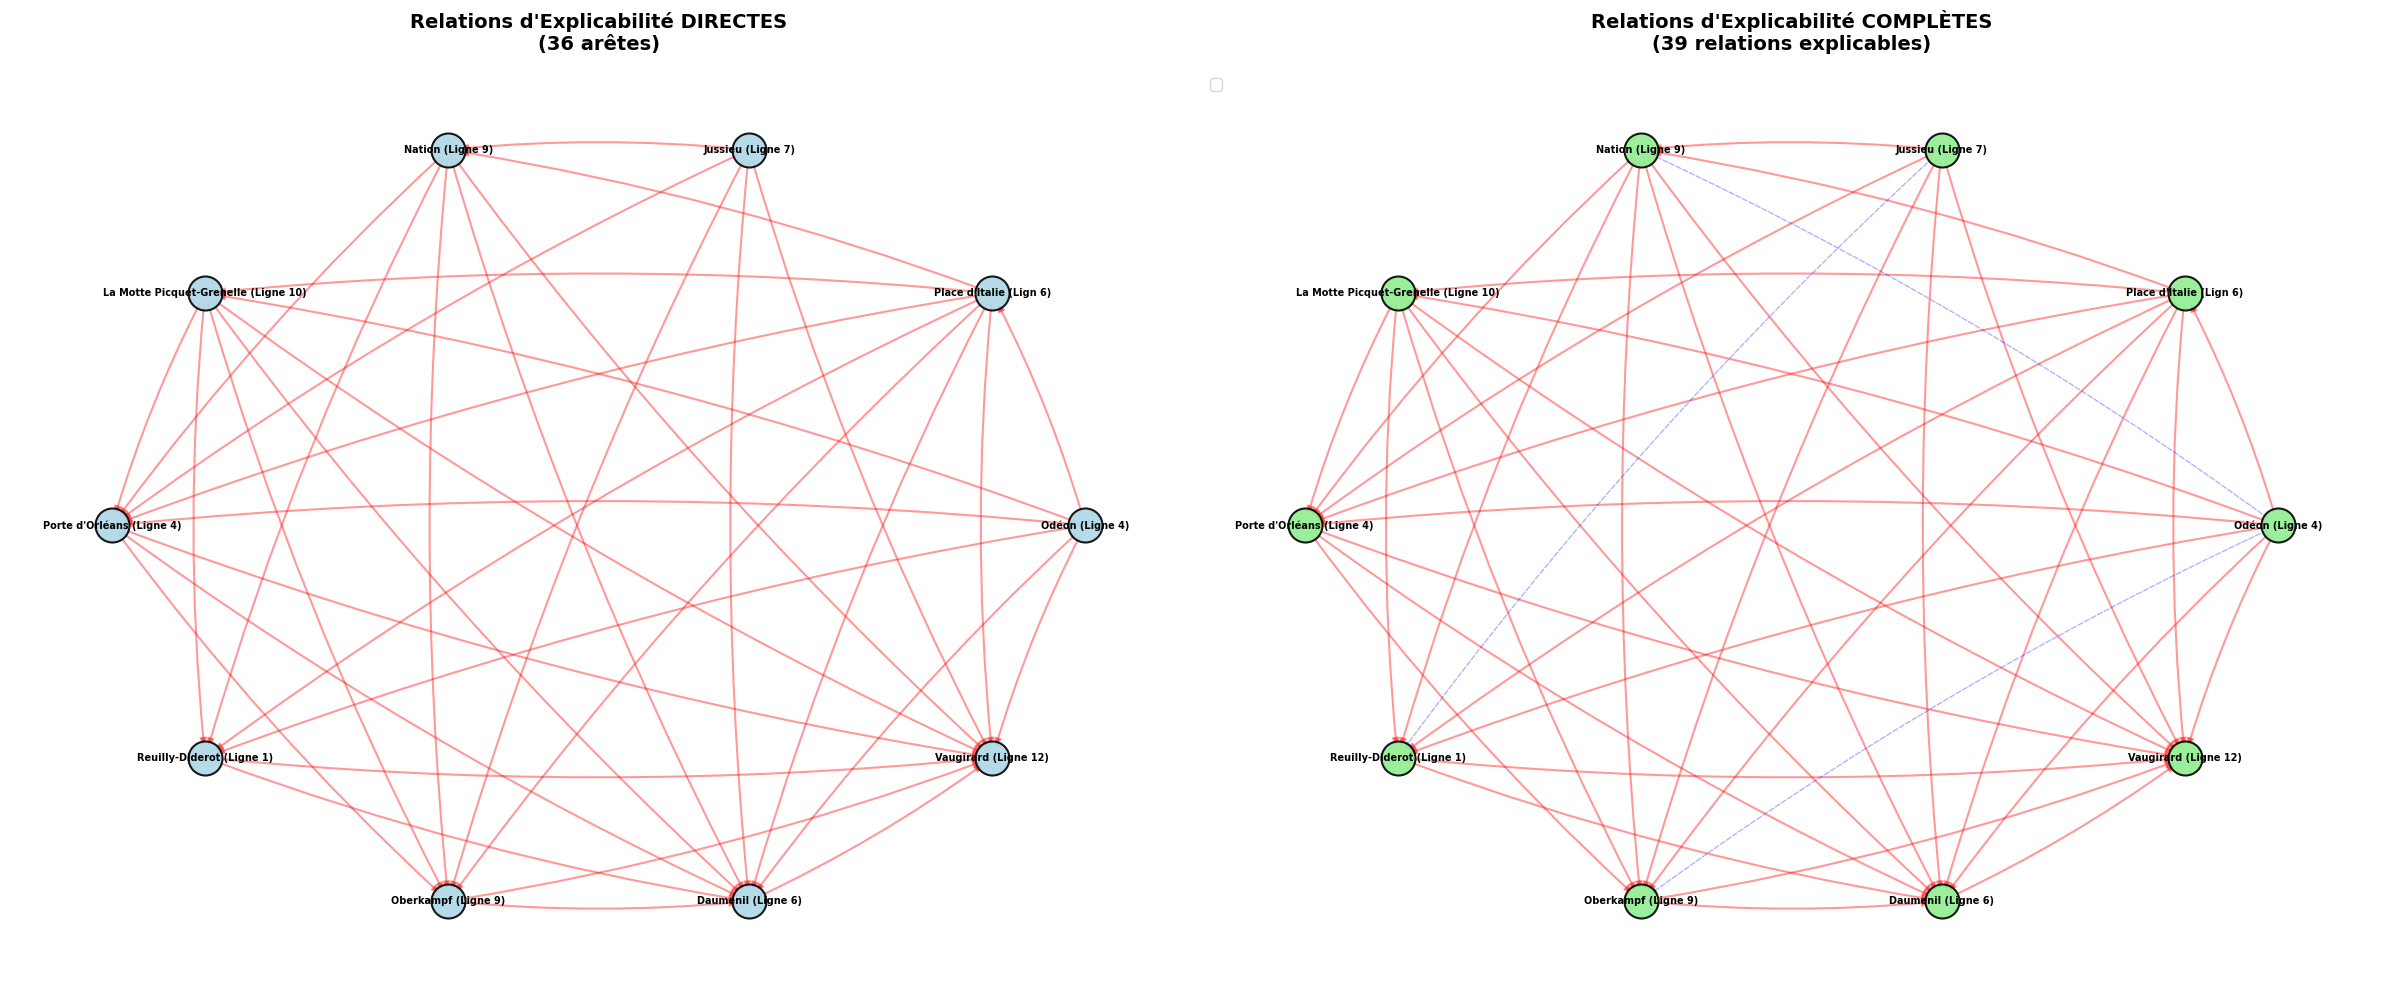


Comparaison visuelle:
  - GAUCHE: Explicabilité directe uniquement
  - DROITE: Explicabilité complète (directe + transitive)
  - Arêtes rouges pleines = explications directes
  - Arêtes bleues pointillées = explications indirectes (via chemins)


In [50]:
# Visualisation comparée : avec et sans transitivité
fig, axes = plt.subplots(1, 2, figsize=(24, 10))

# Graphe 1: Relations directes uniquement
ax1 = axes[0]
plt.sca(ax1)

# Utiliser la même position pour les deux graphes
pos_viz = {}
sorted_stations = sorted(station_names, key=lambda x: scores_dict[x], reverse=True)
n = len(sorted_stations)
for i, station in enumerate(sorted_stations):
    angle = 2 * np.pi * i / n
    radius = 10
    pos_viz[station] = (radius * np.cos(angle), radius * np.sin(angle))

# Graphe 1: Relations directes
nx.draw_networkx_nodes(G, pos_viz, 
                       node_color='lightblue', 
                       node_size=600,
                       alpha=0.9,
                       edgecolors='black',
                       linewidths=1.5,
                       ax=ax1)

nx.draw_networkx_edges(G, pos_viz,
                      edge_color='red',
                      width=1.5,
                      alpha=0.4,
                      arrows=True,
                      arrowsize=10,
                      arrowstyle='-|>',
                      connectionstyle='arc3,rad=0.05',
                      ax=ax1)

nx.draw_networkx_labels(G, pos_viz, 
                        font_size=7,
                        font_weight='bold',
                        ax=ax1)

ax1.set_title(f"Relations d'Explicabilité DIRECTES\n({num_direct} arêtes)", 
             fontsize=14, fontweight='bold', pad=15)
ax1.axis('off')

# Graphe 2: Relations avec chemins transitifs
ax2 = axes[1]
plt.sca(ax2)

# Créer un nouveau graphe incluant toutes les relations explicables
G_complete = nx.DiGraph()
G_complete.add_nodes_from(station_names)

# Ajouter toutes les relations explicables (directes et indirectes)
for station_a, station_b, _ in direct_explanations:
    G_complete.add_edge(station_a, station_b, relation='direct')

for station_a, station_b, _ in indirect_explanations:
    G_complete.add_edge(station_a, station_b, relation='indirect')

# Séparer les arêtes par type
direct_edges = [(u, v) for u, v, d in G_complete.edges(data=True) if d.get('relation') == 'direct']
indirect_edges = [(u, v) for u, v, d in G_complete.edges(data=True) if d.get('relation') == 'indirect']

# Dessiner les nœuds
nx.draw_networkx_nodes(G_complete, pos_viz, 
                       node_color='lightgreen', 
                       node_size=600,
                       alpha=0.9,
                       edgecolors='black',
                       linewidths=1.5,
                       ax=ax2)

# Dessiner les arêtes directes
if direct_edges:
    nx.draw_networkx_edges(G_complete, pos_viz,
                          edgelist=direct_edges,
                          edge_color='red',
                          width=1.5,
                          alpha=0.4,
                          arrows=True,
                          arrowsize=10,
                          arrowstyle='-|>',
                          connectionstyle='arc3,rad=0.05',
                          label='Direct',
                          ax=ax2)

# Dessiner les arêtes indirectes
if indirect_edges:
    nx.draw_networkx_edges(G_complete, pos_viz,
                          edgelist=indirect_edges,
                          edge_color='blue',
                          width=1,
                          alpha=0.3,
                          arrows=True,
                          arrowsize=8,
                          arrowstyle='-|>',
                          connectionstyle='arc3,rad=0.05',
                          style='dashed',
                          label='Indirect (transitif)',
                          ax=ax2)

nx.draw_networkx_labels(G_complete, pos_viz, 
                        font_size=7,
                        font_weight='bold',
                        ax=ax2)

ax2.set_title(f"Relations d'Explicabilité COMPLÈTES\n({num_direct + num_indirect} relations explicables)", 
             fontsize=14, fontweight='bold', pad=15)
ax2.legend(loc='upper left', fontsize=11)
ax2.axis('off')

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("Comparaison visuelle:")
print("  - GAUCHE: Explicabilité directe uniquement")
print("  - DROITE: Explicabilité complète (directe + transitive)")
print("  - Arêtes rouges pleines = explications directes")
print("  - Arêtes bleues pointillées = explications indirectes (via chemins)")
print("=" * 80)


### 7.6 Synthèse de l'Analyse de Transitivité

**Interprétation des résultats:**

1. **Explications directes** : Préférences explicables par un seul trade-off optimal (une arête dans le graphe)
   
2. **Explications indirectes** : Préférences explicables par une chaîne de trade-offs transitifs
   - Exemple : Si $A$ est préféré à $B$ via un chemin $A \rightarrow C \rightarrow B$, alors:
     - On peut expliquer pourquoi $A \succ C$ (avantages de $A$ sur $C$)
     - On peut expliquer pourquoi $C \succ B$ (avantages de $C$ sur $B$)
     - Par transitivité, on peut construire une explication composite pour $A \succ B$

3. **Préférences inexplicables** : Incohérences potentielles dans le système de pondération ou cas limites où les trade-offs ne sont pas suffisants

**Implications pratiques:**
- Un taux élevé d'explicabilité indirecte suggère que le système de préférences est cohérent et transitif
- Les préférences inexplicables peuvent indiquer des besoins d'ajustement des poids ou critères supplémentaires
- La longueur moyenne des chemins indique la complexité typique des explications transitives

---
## Conclusion

Ce notebook a présenté:

1. **Le modèle de préférence par somme pondérée** pour classer les stations RATP

2. **Trois modélisations d'explicabilité** basées sur la programmation linéaire:
   - **(1-m)**: Un avantage compense plusieurs désavantages
   - **(m-1)**: Plusieurs avantages compensent un désavantage
   - **Hybride**: Combinaison optimale des deux approches

3. **Une analyse complète** de l'explicabilité entre toutes les paires de stations

Les modèles utilisent Gurobi pour résoudre des problèmes d'optimisation en nombres entiers, garantissant des explications minimales et optimales.

### Points clés:
- La plupart des préférences peuvent être expliquées par des trade-offs simples
- L'approche hybride offre plus de flexibilité pour les cas complexes
- Certaines comparaisons restent inexplicables selon ce cadre théorique